In [2]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *

import keras
import tensorflow

In [3]:
frame = pd.read_csv("../data/simulations_truth/harmonic_scatters.csv")

In [4]:
energies = []
total_interactions = 0
interaction_times = []
total_times = []

for i in range(len(frame)-1):
    if frame["File_name"][i] == frame["File_name"][i+1]:
        energies.append(frame["Energy [eV]"][i] - frame["Energy [eV]"][i+1])
        total_interactions += 1
        interaction_times.append(frame["Time [seconds]"][i+1] - frame["Time [seconds]"][i])

    else:
        total_times.append(frame["Time [seconds]"][i])
        
energies = np.array(energies)


file_names = pd.read_csv("../data/simulations_truth/harmonic_scatter_filenames.csv")

# frame.head()

Training data:

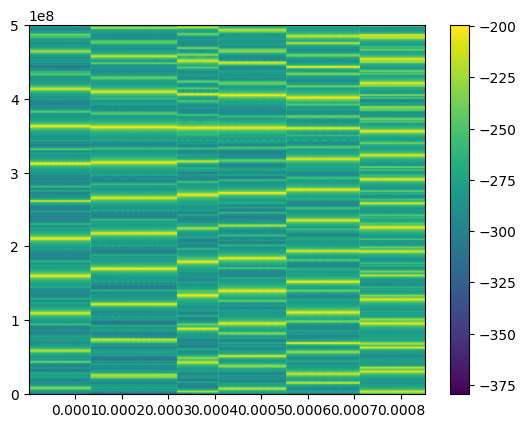

In [5]:
file_names = np.array(file_names)
test_file = file_names[0][0]
strings, attributes, attributes_values = get_attributes(test_file, full_path=False)
signal = get_signal(test_file, strings[0])

IMG = plt.specgram(signal, NFFT=1024, Fs=1e9, noverlap=900)[:3]
plt.colorbar()

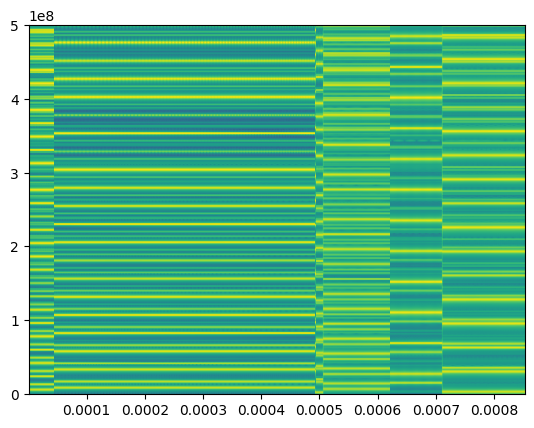

In [6]:
file_names = np.array(file_names)

training_data = []


for i in range(10):

    file_ = file_names[i][0]

    strings, attributes, attributes_values = get_attributes(file_, full_path=False)
    signal = get_signal(file_, strings[0])

    IMG = plt.specgram(signal, NFFT=1024, Fs=1e9, noverlap=900)[:3]

    training_data.append(IMG)

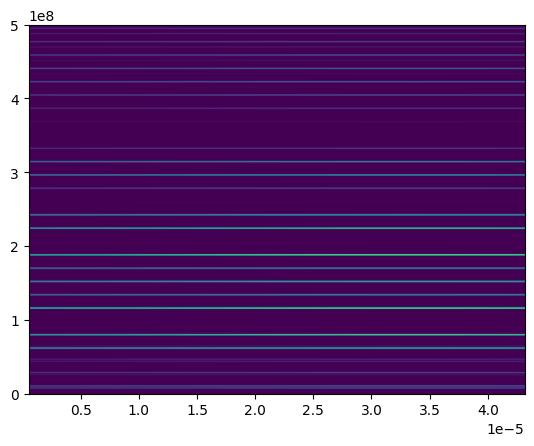

In [7]:
slice = 100

plt.imshow(IMG[0], aspect='auto', extent=[np.min(IMG[2]), np.max(IMG[2]),
                                          np.min(IMG[1]), np.max(IMG[1])]);

In [8]:
keras.Model()

Making a model

In [14]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models

In [24]:
t_data = np.array(training_data)
np.shape(t_data[5][0])

/var/folders/cl/l2qg34px6s96_4z813158xdh0000gn/T/ipykernel_79889/1936630466.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t_data = np.array(training_data)


(513, 483)

In [15]:

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(129, 22, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='relu'))

Problems to solve:

- What is our output?
    - Array of specific scatter time indices? (e.g. if there is a single scatter -> output = [X], where X is time index of scatter location)
        - How do we monitor accuracy, distance from true scatter? Have a feeling we will be plagued with ghost scatters.
    - Output along time axis list of probabilities of scatter.
        - but how do we get the probability? do we do this using a prior and use bayesian inference, matching against standard interaction time? No feels off. 
        - how about validating the energy of slices 


- We need a smart, robust, adaptive method of detecting scatters. 


- Alternative approaches 
    - GNN node finding. Find ends of tracks and hence scatters on specgram images.
    - Tuning the images? 
    - Rotation invariance, is there any point in regularising like for other computer vision applications?


Do we need to take a step back and take specific slices of spectrograms? Or do we need to pad grams to bolster our adaptability. 


How will the detection perform under gaussian noise, other noise? artefacts? and for different normalisations. Need to ponder whether normalising to the maximum power in the gram makes sense or if the magnitude is as important as the relative magnitude. 